In [42]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd

pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

In [43]:
def get_pickles(): 
    x_train = pickle.load(open(f'../../data/processed/pickles/region_x_train.p', 'rb'))
    x_test = pickle.load(open(f'../../data/processed/pickles/region_x_test.p', 'rb'))
    y_train = pickle.load(open(f'../../data/processed/pickles/region_y_train.p', 'rb'))
    y_test = pickle.load(open(f'../../data/processed/pickles/region_y_test.p', 'rb'))
    X = pickle.load(open('../../data/processed/pickles/region_X.p', 'rb'))
    y = pickle.load(open('../../data/processed/pickles/region_y.p', 'rb'))

    return (x_train, x_test, y_train, y_test), (X,y)

(x_train, x_test, y_train, y_test), (X,y) = get_pickles()

unique_regions = X.region.unique() 
print(f'Original X: {X.shape}\tOriginal y: {y.shape}')
print(f'Train X: {x_train.shape}\tTrain y: {y_train.shape}')
print(f'Test X: {x_test.shape}\tTest y: {y_test.shape}')

y_train = y_train.target.values.ravel()
y_test = y_test.target.values.ravel()
y = y.target.values.ravel()

standard = StandardScaler() 
x_train[['amount_tsh', 'gps_height', 
         'population', 'time_passed']] = standard.fit_transform(x_train[['amount_tsh', 
                                                                         'gps_height', 'population', 'time_passed']])

Original X: (57247, 54)	Original y: (57247, 1)
Train X: (42935, 54)	Train y: (42935, 1)
Test X: (14312, 54)	Test y: (14312, 1)


In [44]:
X['target'] = y
x_test['target'] = y_test
x_train['target'] = y_train

### Baseline Testing for Models and Stacked

In [45]:

models = {'log': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'dt': DecisionTreeClassifier(), 'Gaussian': GaussianNB(), 'LDA': LinearDiscriminantAnalysis(),
          'LinearSVC': LinearSVC(max_iter = 1250), 'SDGSVC': SGDClassifier(),  
          'rf': RandomForestClassifier(),
        }
#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model
unique_reg = list(enumerate(unique_regions))
pbar = tqdm(unique_reg)
final_results = {}
for idx, reg in pbar:
    #test each model and stacking
    results = []
    model_names = []
    for idx2, (model, m) in enumerate(models.items()): 
        pbar.set_description(f'({idx}/{len(unique_regions)}){reg}: Evaluating {model.upper()} {idx2}/{len(models)}')
        cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 10)
        y_region = X[X.region==reg].target.values
        x_region = X[X.region == reg].drop(['region', 'target'], axis =1)
        scores = cross_val_score(m, x_region, y_region, scoring = 'accuracy', cv = cv, n_jobs = 12, 
                                 error_score = 'raise')
        results.append(scores)
        model_names.append(model)
    final_results[reg] = {'results': results, 'model_names': model_names}

    

(20/21)Mtwara: Evaluating STACKED 8/9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [09:00<00:00, 25.72s/it]


In [46]:
pickle.dump(final_results, open('../../models/RegionVanillaResults.p', 'wb'))
final_results

{'Iringa': {'results': [array([0.88      , 0.85904762, 0.87809524, 0.86857143, 0.88190476,
          0.87047619, 0.87238095, 0.87047619, 0.8759542 , 0.8740458 ,
          0.86857143, 0.8952381 , 0.87428571, 0.87428571, 0.86285714,
          0.87047619, 0.86095238, 0.87428571, 0.8740458 , 0.88549618,
          0.88952381, 0.86857143, 0.86285714, 0.88      , 0.87428571,
          0.87428571, 0.87809524, 0.87238095, 0.8778626 , 0.8740458 ,
          0.88380952, 0.89333333, 0.84952381, 0.88190476, 0.87809524,
          0.86285714, 0.8552381 , 0.88571429, 0.8740458 , 0.86259542,
          0.88571429, 0.88952381, 0.85333333, 0.87428571, 0.8552381 ,
          0.87619048, 0.87619048, 0.87809524, 0.85496183, 0.8778626 ]),
   array([0.80761905, 0.82285714, 0.82666667, 0.82285714, 0.81714286,
          0.80761905, 0.81142857, 0.79428571, 0.80152672, 0.83015267,
          0.80190476, 0.80571429, 0.81714286, 0.81904762, 0.80952381,
          0.81904762, 0.81714286, 0.8       , 0.81679389, 0.8072519

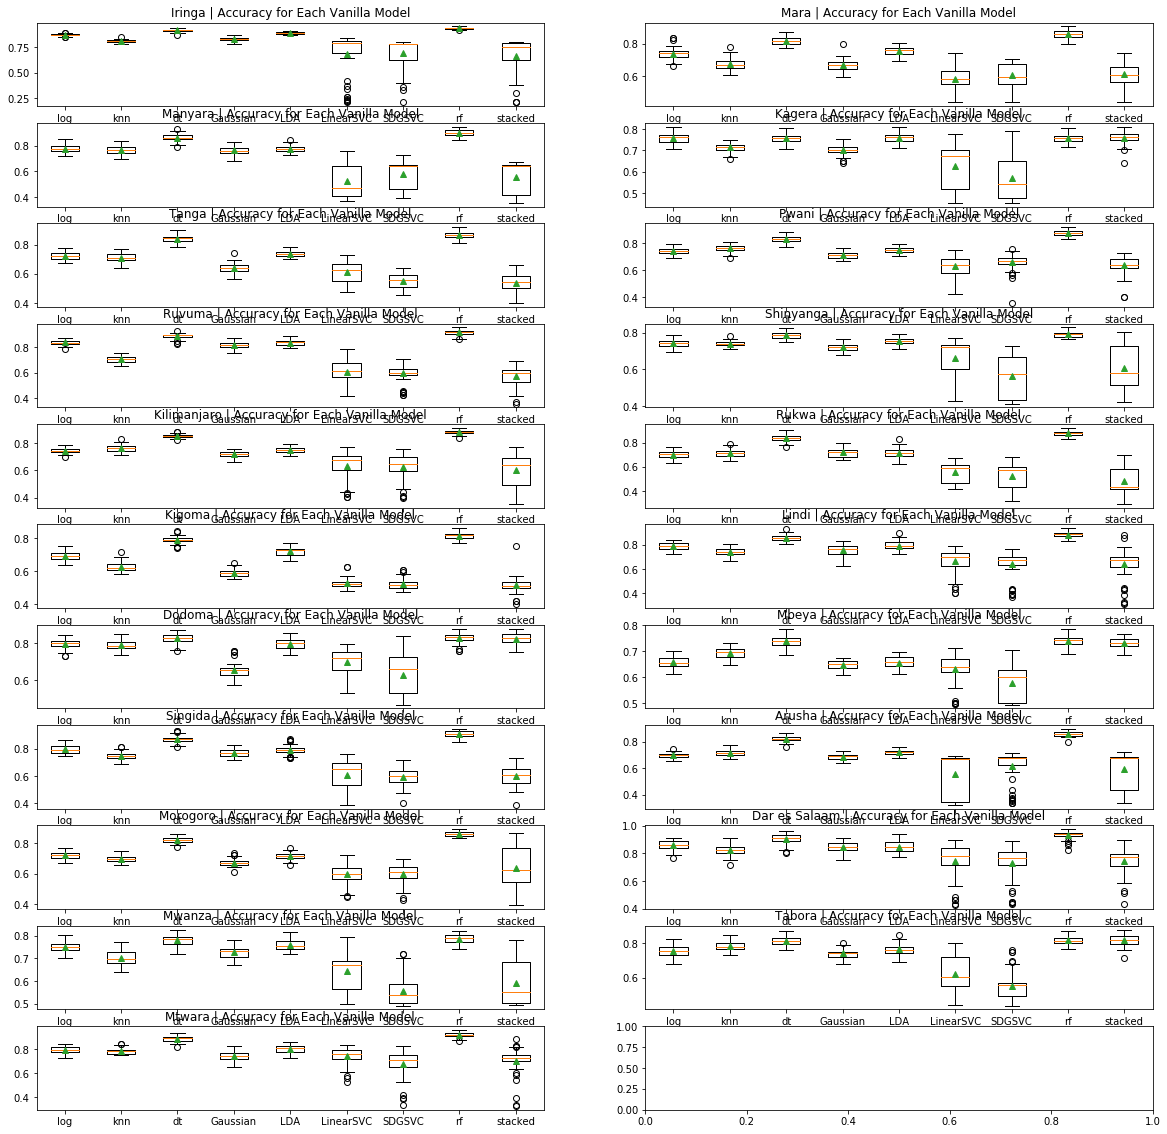

In [47]:
fig, ax =plt.subplots(len(final_results)//2+1, 2, figsize = (20,20))

for i, reg in enumerate(final_results.keys()): 
    results = final_results[reg]['results']
    model_names = final_results[reg]['model_names']
    idx1 = i //2
    idx2 = i % 2
#     print(idx1, idx2)
    ax[idx1, idx2].boxplot(results, labels = model_names, showmeans = True)
    ax[idx1, idx2].set_title(f'{reg} | Accuracy for Each Vanilla Model')
#     ax[idx1, idx2].set_ylabel('Accuracy')
#     ax[idx1, idx2].set_xlabel('Model')
    
    


In [50]:
iringa_df_train = x_train[x_train.region == 'Iringa']
iringa_x_train = iringa_df_train[[i for i in x_train.columns if i not in ['target', 'region']]]
iringa_y_train = iringa_df_train[['target']].values.ravel()

iringa_df_test = x_test[x_test.region == 'Iringa']
iringa_x_test = iringa_df_test[[i for i in x_test.columns if i not in ['target', 'region']]]
iringa_y_test = iringa_df_test[['target']].values.ravel()

iringa_x_train
log = LogisticRegression(max_iter = 5000)
log.fit(iringa_x_train, iringa_y_train)
print(log.score(iringa_x_test,iringa_y_test))

0.7827743902439024


In [51]:

print(iringa_df_train.shape) 
iringa_df_test.shape

(3936, 55)


(1312, 55)

In [57]:
iringa_df_train = x_train[x_train.region == 'Mtwara']
iringa_x_train = iringa_df_train[[i for i in x_train.columns if i not in ['target', 'region']]]
iringa_y_train = iringa_df_train[['target']].values.ravel()

iringa_df_test = x_test[x_test.region == 'Mtwara']
iringa_x_test = iringa_df_test[[i for i in x_test.columns if i not in ['target', 'region']]]
iringa_y_test = iringa_df_test[['target']].values.ravel()

iringa_x_train
log = RandomForestClassifier()
log.fit(iringa_x_train, iringa_y_train)
print(log.score(iringa_x_test,iringa_y_test))

0.7692307692307693
